# Images classification

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy

### Loading MNIST, dataset with hand-written numbers

In [2]:
import torch
from torchvision import datasets, transforms
from torch.autograd import Variable

In [3]:
# download data, transform it (to tensor and normalize images)
# the result is iterator over batches 
batch_size = 64

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=batch_size, shuffle=True)

Processing...
Done!


### Plot images

(64, 1, 28, 28)


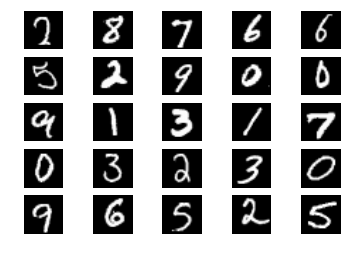

In [4]:
for (data, target) in train_loader:
    samples = data.numpy()
    print samples.shape
    for i in range(25):
        plt.subplot(5, 5, i + 1)
        plt.imshow(samples[i, 0, :, :], cmap='gray')
        plt.axis('off')
    break # only for a first batch

## Define NN configuration

- convolution layer, max pooling, activation
- convolution layer, dropout, max pooling, activation
- flattening
- dense layer, activation, dropout
- dense layer

In [5]:
from torch.nn import Sequential, Conv2d, Dropout2d, Linear, MaxPool2d, Softmax, ReLU
from torch.optim import SGD, Adagrad, Adadelta

In [6]:
# define flattening layer
class Flatten(torch.nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(len(x), -1)

In [7]:
# define NN configuration
model = Sequential(
    Conv2d(1, 10, kernel_size=5), # one image, apply 10 filters, each filter is a matrix 5x5 -> 10 images with size 24x24
    MaxPool2d(kernel_size=2), # maxpool operation, compress each of 10 images twice -> images with size 12X12
    ReLU(), # add non linear activation
    Conv2d(10, 20, kernel_size=5), # 10 images, apply 20 filters, each filter is a matrix 5x5 -> 20 images with size 8x8
    Dropout2d(p=0.5), # deactivate neuron with probability 0.5 during training
    MaxPool2d(kernel_size=2), # maxpool operation, compress each of 20 images twice -> 20 images with size 4X4
    ReLU(), # add non linear activation
    Flatten(), # 20 images with size 4x4 = 320 values
    Linear(320, 50), # add dense layer
    ReLU(), # add non linear activation
    Dropout2d(p=0.5), # deactivate neuron with probability 0.5 during training
    Linear(50, 10), # dense layer, output is equal to number of classes
)

# define optimizer
optimizer = SGD(model.parameters(), lr=0.01, momentum=0.8)

## Training function

In [8]:
from torch.nn import CrossEntropyLoss

def train(epoch, train_loader, model, optimizer, log_interval=100):
    # define loss function
    loss_function = CrossEntropyLoss()
    # set training mode for correctness of Dropout layer
    model.train()
    # iterate over batches
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        # set gradient to zero
        optimizer.zero_grad()
        # compute output of NN
        output = model(data)
        # compute loss function (logistic loss)
        loss = loss_function(output, target)
        # propagate gradients
        loss.backward()
        # make optimization step
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data[0]))

## Test function

In [9]:
from torch.nn.functional import softmax


def test(epoch, train_loader, model, optimizer):
    # set evaluation mode for correctness of Dropout layer
    model.eval()
    
    test_loss = 0
    correct = 0
    
    loss_function = CrossEntropyLoss()
    
    # iterate over test samples
    for data, target in test_loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data)
        test_loss += loss_function(output, target).data[0]
        # compute probabilities for each class
        proba = softmax(output).data.numpy() 
        # compute class answers
        target_predicted = proba.argmax(axis=1)
        correct += numpy.sum(target_predicted == target.data.numpy())

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


## Train/test the NN

In [10]:
epochs = 3

for epoch in range(1, epochs + 1):
    train(epoch, train_loader, model, optimizer)
    test(epoch, train_loader, model, optimizer)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.330248
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.977603
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.839784
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.566482
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.377513
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.484473
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.349985
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.263893
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.259025
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.376070

Test set: Average loss: 0.1055, Accuracy: 9668/10000 (96.680%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.300064
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.142655
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.324350
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.273088
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.333883
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.077410
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.273606
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.201035
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.1343

## Optional exercises

1. fine-tune the network above and look at misclassified images. For tuning, you can use the [this approach](http://i.imgur.com/bSiNEq6.gif)

2. compare two optimizers: `SGD` (simple stochastic SGD) and `Adadelta` (AdaDelta) on this dataset and study their performance depending on the number of hidden layers.

# Want to play with more complicated example?

Recognize letters from different fonts from notMNIST dataset. Download data from [here](http://yaroslavvb.com/upload/notMNIST/)

To load dataset from `.mat` format use `loadmat` function:
```
    from scipy.io import loadmat
    data = loadmat('notMNIST_small.mat')
    # plot the first image
    plt.imshow(data['images'][:, :, 0], cmap='gray')
```

To load image from `.png` use the following code:
```
    from scipy.misc import imread
    img = imread('file.png')
    # plot the image
    plt.imshow(img, cmap='gray')
```

# References
- [pytorch documentation](http://pytorch.org/tutorials/)
- [keras](https://keras.io) is another popular high-level interface for neural networks
- neural networks [playground](http://playground.tensorflow.org)